# ERCOT Data Case Study

### By: Dylan Bolt

In [413]:
#Load in packages 

import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics

warnings.filterwarnings('ignore')

## Q1: Read data into Python

In [414]:
#Read in data

ercot = pd.read_csv('ErcotQ22019.csv')

#Take a look at data types and first 5 rows

print(ercot.info())
ercot.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53006 entries, 0 to 53005
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date/Time                              53006 non-null  object 
 1   ERCOT (RT_ORD_PRADDER) Average         52990 non-null  float64
 2   ERCOT (RT_ON_CAP) Average              52976 non-null  float64
 3   ERCOT (HASL) Average                   51125 non-null  float64
 4   ERCOT (RTLOAD) Average                 52923 non-null  float64
 5   ERCOT (GENERATION_SOLAR_RT) Average    53005 non-null  float64
 6   ERCOT (SOLAR_PVGRPP_BIDCLOSE) Average  52993 non-null  float64
 7   ERCOT (WINDDATA) Average               53005 non-null  float64
 8   ERCOT (WIND_COPHSL_BIDCLOSE) Average   53005 non-null  float64
 9   ERCOT (SYSTEM_LAMBDA) Average          52983 non-null  float64
 10  HB_WEST (RTLMP) Average                52986 non-null  float64
dtypes:

,Date/Time,ERCOT (RT_ORD_PRADDER) Average,ERCOT (RT_ON_CAP) Average,ERCOT (HASL) Average,ERCOT (RTLOAD) Average,ERCOT (GENERATION_SOLAR_RT) Average,ERCOT (SOLAR_PVGRPP_BIDCLOSE) Average,ERCOT (WINDDATA) Average,ERCOT (WIND_COPHSL_BIDCLOSE) Average,ERCOT (SYSTEM_LAMBDA) Average,HB_WEST (RTLMP) Average
0,7/1/2019 0:00,0.0,15169.23,NaN,42776.0,0.0,0.0,10461.96,9986.6,15.68,15.68
1,7/1/2019 0:05,0.0,15492.86,11832.0,42482.0,0.0,0.0,10546.14,10479.4,15.43,15.43
2,7/1/2019 0:10,0.0,15472.23,12035.0,42190.0,0.0,0.0,10549.36,10479.4,15.41,15.41
3,7/1/2019 0:15,0.0,15196.71,11860.0,42034.0,0.0,0.0,10511.47,10479.4,15.70,15.70
4,7/1/2019 0:20,0.0,15280.22,11980.0,41781.0,0.0,0.0,10454.60,10479.4,15.68,15.68


## Q2: Clean Data

In [415]:
#First, let's change the column headers as suggested

ercot = ercot.rename(columns = {
    "Date/Time":"DATETIME",
    "ERCOT (RT_ORD_PRADDER) Average":"RT_OR_PRADDER",
    "ERCOT (RT_ON_CAP) Average":"RT_ON_CAP",
    "ERCOT (HASL) Average":"HASL",
    "ERCOT (RTLOAD) Average":"RTLOAD",
    "ERCOT (GENERATION_SOLAR_RT) Average":"PVACTUAL",
    "ERCOT (SOLAR_PVGRPP_BIDCLOSE) Average":"PVFORECASTED",
    "ERCOT (WINDDATA) Average":"WINDACTUAL",
    "ERCOT (WIND_COPHSL_BIDCLOSE) Average":"WINDFORECASTED",
    "ERCOT (SYSTEM_LAMBDA) Average":"ERCOTRTPRICE",
    "HB_WEST (RTLMP) Average":"HBWESTRTPRICE"
                                })

In [416]:
#We can see that the "Date/Time" column is read as object 
#Other numeric columns read as float64--all is good there

#Parse dates to convert into datetime type
ercot['DATETIME_PARSED'] = pd.to_datetime(ercot['DATETIME'], format = '%m/%d/%Y %H:%M')

ercot['DATETIME_PARSED']

0       2019-07-01 00:00:00
1       2019-07-01 00:05:00
2       2019-07-01 00:10:00
3       2019-07-01 00:15:00
4       2019-07-01 00:20:00
                ...        
53001   2019-12-31 23:40:00
53002   2019-12-31 23:45:00
53003   2019-12-31 23:50:00
53004   2019-12-31 23:55:00
53005   2020-01-01 00:00:00
Name: DATETIME_PARSED, Length: 53006, dtype: datetime64[ns]

In [417]:
#Next, I'll check how many NAs are present

#Get the number of missing data points per column
missing_values_count = ercot.isnull().sum()

# look at the # of missing points for each column
print(missing_values_count)

DATETIME              0
RT_OR_PRADDER        16
RT_ON_CAP            30
HASL               1881
RTLOAD               83
PVACTUAL              1
PVFORECASTED         13
WINDACTUAL            1
WINDFORECASTED        1
ERCOTRTPRICE         23
HBWESTRTPRICE        20
DATETIME_PARSED       0
dtype: int64


In [418]:
#Remove NAs and check difference in data points

ercot_cleaned = ercot.dropna()

print(f'Rows in original dataset: {ercot.shape[0]}')
print(f'Rows with NAs dropped: {ercot_cleaned.shape[0]}')
print(f'Number of rows dropped: {(ercot.shape[0] - ercot_cleaned.shape[0])}')
print(f'Percentage of rows dropped: {round((ercot.shape[0] - ercot_cleaned.shape[0])/(ercot.shape[0]) * 100,2)}%')

Rows in original dataset: 53006
Rows with NAs dropped: 51018
Number of rows dropped: 1988
Percentage of rows dropped: 3.75%


In [419]:
# date = ercot['DATETIME'].str.split(' ').str[0]
# time = ercot['DATETIME'].str.split(' ').str[1]

# print(date)
# print(time)

## Q3: Exploratory Data Analysis

In [420]:
ercot_cleaned['ERCOTRTPRICE'].describe()

count    51018.00000
mean        33.80571
std        195.97198
min        -10.90000
25%         16.35000
50%         19.22000
75%         27.02000
max       9001.00000
Name: ERCOTRTPRICE, dtype: float64

<AxesSubplot:xlabel='ERCOTRTPRICE', ylabel='Count'>

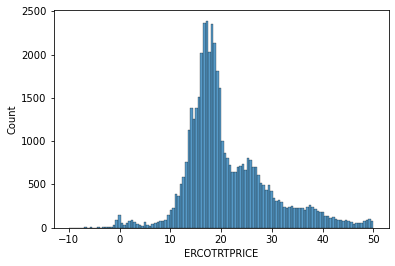

In [421]:
sns.histplot(ercot_cleaned['ERCOTRTPRICE'], binrange = (-10,50))

<AxesSubplot:xlabel='RTLOAD', ylabel='Count'>

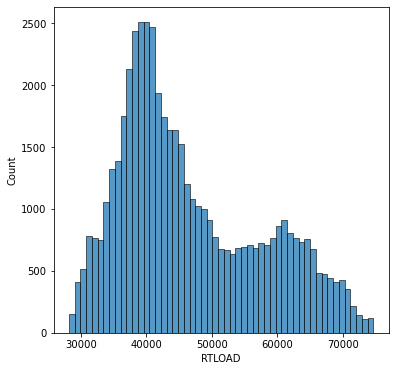

In [422]:
plt.subplots(figsize=(6,6))
sns.histplot(ercot_cleaned['RTLOAD'])


<AxesSubplot:xlabel='PVACTUAL', ylabel='PVFORECASTED'>

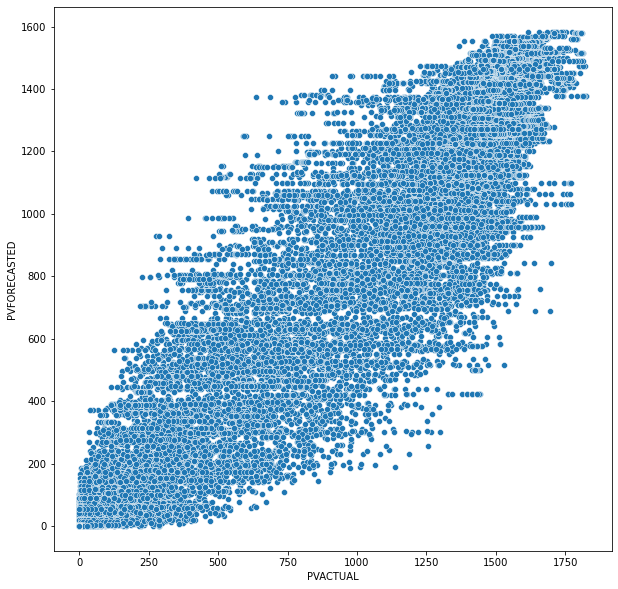

In [423]:
plt.subplots(figsize = (10,10))


sns.scatterplot(data = ercot_cleaned, x = 'PVACTUAL', y = 'PVFORECASTED')



In [424]:
#.describe() method summarizes data by mean, median(50% quartile value), 
#max, quartiles, and standard deviation

ercot_summary = ercot_cleaned.describe()
ercot_summary

,RT_OR_PRADDER,RT_ON_CAP,HASL,RTLOAD,PVACTUAL,PVFORECASTED,WINDACTUAL,WINDFORECASTED,ERCOTRTPRICE,HBWESTRTPRICE
count,51018.000000,51018.000000,51018.000000,51018.000000,51018.000000,51018.000000,51018.000000,51018.000000,51018.00000,51018.000000
mean,4.077940,11387.948914,7962.960073,46648.975992,500.260253,426.106045,8586.733107,8555.587238,33.80571,29.891262
std,138.006882,4631.766482,4516.791446,10802.935284,632.119004,550.028681,4327.961047,4291.787640,195.97198,196.577597
min,0.000000,1886.410000,60.000000,28187.000000,-0.830000,0.000000,206.930000,509.000000,-10.90000,-27.010000
25%,0.000000,7608.510000,4344.000000,38498.000000,-0.080000,0.000000,4953.902500,4996.500000,16.35000,14.180000
50%,0.000000,10801.855000,7237.000000,43591.000000,2.455000,9.300000,8319.240000,8070.800000,19.22000,17.930000
75%,0.000000,14292.705000,10728.000000,54790.500000,1204.817500,976.000000,12180.767500,11910.600000,27.02000,23.670000
max,7177.020000,29682.290000,26381.000000,74673.000000,1826.310000,1583.000000,19137.860000,20204.300000,9001.00000,9040.840000


In [425]:
#Access the the 3rd quartile value (75%) for WINDACTUAL

windactual_3rdQ = ercot_summary.loc['75%','WINDACTUAL']

print(f"Third quartile of 'WINDACTUAL': {windactual_3rdQ} MW")

Third quartile of 'WINDACTUAL': 12180.7675 MW


In [426]:
#Use 3rd quartile value to create new dataframe 
#where all instances have a 'WINDACTUAL' value at or above the 3rd quartile

ercot_windacutal_3rdQ = ercot_cleaned.loc[ercot_cleaned['WINDACTUAL'] >= windactual_3rdQ, ]

#Check that the resulting dataframe has correct values for 'WINDACTUAL'
ercot_windacutal_3rdQ['WINDACTUAL'].min()

12180.98

In [427]:
#Compare ERCOTRTPRICE means across both dataframes 

original_mean = ercot_cleaned['ERCOTRTPRICE'].mean()
upper_windactual_mean = ercot_windacutal_3rdQ['ERCOTRTPRICE'].mean()
mean_diff = abs(ercot_cleaned['ERCOTRTPRICE'].mean() - ercot_windacutal_3rdQ['ERCOTRTPRICE'].mean())
percent_diff = round((ercot_windacutal_3rdQ['ERCOTRTPRICE'].mean()/ercot_cleaned['ERCOTRTPRICE'].mean())*100,2)

print(f"'ERCOTRTPRICE' mean of original dataframe: {original_mean} $/MWh")
print(f"'ERCOTRTPRICE' mean of new dataframe: {upper_windactual_mean} $/MWh")
print(f" Difference in means: {mean_diff} $/MWh")
print(f" Percent decrease in means: {percent_diff}%")

'ERCOTRTPRICE' mean of original dataframe: 33.8057095534911 $/MWh
'ERCOTRTPRICE' mean of new dataframe: 18.228114464915684 $/MWh
 Difference in means: 15.577595088575414 $/MWh
 Percent decrease in means: 53.92%


In [428]:
#We can see that the energy price for the solar systems decreased substanially
#I wonder if solar energy produced ("PVACTUAL") has a similar drop
#The percent decrease in means is similar


original_mean = ercot_cleaned['PVACTUAL'].mean()
upper_windactual_mean = ercot_windacutal_3rdQ['PVACTUAL'].mean()
mean_diff = abs(ercot_cleaned['PVACTUAL'].mean() - ercot_windacutal_3rdQ['PVACTUAL'].mean())
percent_diff = round((ercot_windacutal_3rdQ['PVACTUAL'].mean()/ercot_cleaned['PVACTUAL'].mean())*100,2)


print(f"'PVACTUAL' mean of original dataframe: {original_mean} MW")
print(f"'PVACTUAL' mean of new dataframe: {upper_windactual_mean} MW")
print(f" Difference in means: {mean_diff} MW")
print(f" Percent decrease in means: {percent_diff}%")

'PVACTUAL' mean of original dataframe: 500.26025265595126 MW
'PVACTUAL' mean of new dataframe: 240.6344860838882 MW
 Difference in means: 259.62576657206307 MW
 Percent decrease in means: 48.1%


## Q4: Model Preparation & Feature Creation

<AxesSubplot:>

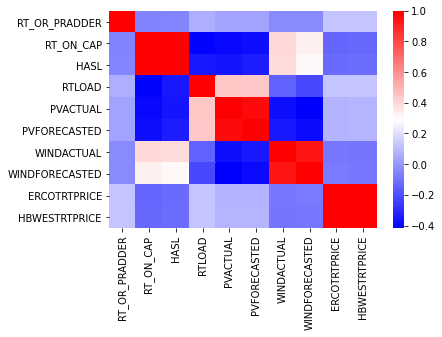

In [429]:
#Check correlations 
#Red indicates a strong positive relationship
#Blue indicates a strong negative relationship

sns.heatmap(ercot_cleaned.corr(), cmap = 'bwr')

In [430]:
#Create numerical time and date features from the parsed 'DATETIME' column


ercot_cleaned['week'] = ercot_cleaned['DATETIME_PARSED'].dt.week
ercot_cleaned['day'] = ercot_cleaned['DATETIME_PARSED'].dt.day
ercot_cleaned['weekday'] = ercot_cleaned['DATETIME_PARSED'].dt.weekday
ercot_cleaned['hour'] = ercot_cleaned['DATETIME_PARSED'].dt.hour
ercot_cleaned['month'] = ercot_cleaned['DATETIME_PARSED'].dt.month


<AxesSubplot:xlabel='month', ylabel='PVACTUAL'>

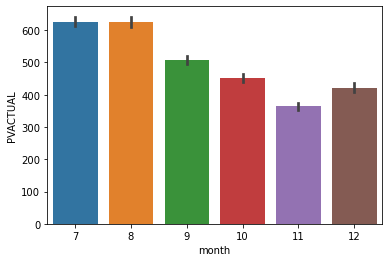

In [431]:
#Barplot to compare how much power is used in each month.
#As expected, less energy is used in the winter months in Texas. (Likely due to less need for AC)


sns.barplot(data = ercot_cleaned, x = 'month', y = 'PVACTUAL')

In [432]:
#Create a discrete target variable which tells our model whether an instance encountered solar curtailment
#Solar curtailment occurs when 'ERCOTRTPRICE' is less than 0 $/MWh
#This column will take the value 1 if solar curtailment occurs, and 0 otherwise

ercot_cleaned['SOLAR_CURTAILMENT'] = np.where(ercot_cleaned['ERCOTRTPRICE'] < 0, 1,0)

solar_curtailment_values = ercot_cleaned['SOLAR_CURTAILMENT'].value_counts()

print(f'Percent of instances with solar curtailment: \
{round((solar_curtailment_values[1]/solar_curtailment_values[0]) * 100,3)} %')

Percent of instances with solar curtailment: 0.401 %


In [433]:
#Split dataframe in X (predictor variables) and y (target variable)

#I'm choosing not to include "HBWESTRTPRICE" due to target leakage

#This variable almost perfectly predicts our target as seen in the high correlation
#between "HBWESTRTPRICE" and "ERCOTRTPRICE" above

#I'm assuming this information would not be available at the time of prediction

included_variables = ['week',
                   'day',
                   'weekday',
                   'month',
                   'hour',
                   'RT_OR_PRADDER',
                   'RT_ON_CAP',
                   'HASL',
                   'RTLOAD',
                   'PVACTUAL',
                   'PVFORECASTED',
                   'WINDACTUAL',
                   'WINDFORECASTED']

X = ercot_cleaned[included_variables]

y = ercot_cleaned['SOLAR_CURTAILMENT']

## Modeling with Logisitic Regression

In [434]:
#Perform a train-test split
#Make sure to stratify on our target to ensure both sets have a proportional amount of positive instances


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, stratify = y, random_state = 0)

In [435]:
#create object for regression

logiReg = LogisticRegression() 

#train the data set

logiReg.fit(X_train, y_train)  

#predict the test set 

prediction = logiReg.predict(X_test)

In [436]:
print(classification_report(y_test, prediction)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15245
           1       0.84      0.61      0.70        61

    accuracy                           1.00     15306
   macro avg       0.92      0.80      0.85     15306
weighted avg       1.00      1.00      1.00     15306



In [437]:
#Trying a different threshold value

#A lower threshold effectively lowers the probability
#that is required for our model to classify the instance as positive (solar curtailment occurs)

def threshold_prediction(probs, tau):
    return np.where(probs[:,1]> tau, 1,0)

print(classification_report(y_test, threshold_prediction(logiReg.predict_proba(X_test), .3)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15245
           1       0.59      0.82      0.68        61

    accuracy                           1.00     15306
   macro avg       0.79      0.91      0.84     15306
weighted avg       1.00      1.00      1.00     15306



In [438]:
#Simple accuracy
#Not the best metric for this task

logiReg.score(X_test, y_test)

0.9979746504638703

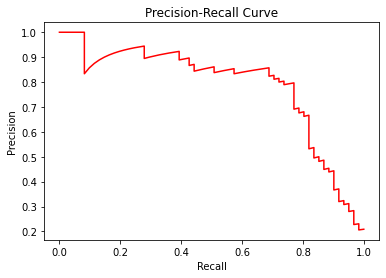

In [439]:
#calculate precision and recall
y_score = logiReg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='r')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()